In [1]:
#exif2track - script to plot photo locations
import __future__
import sys
# argument parsing
import argparse
# glob for files
import glob
# file path tools
import os
# os.path import join, basename, splitdrive, split
# regular expression
import re
# math library
import math
# Numpy
import numpy as np

# GDAL Python library
from osgeo import osr
# EXIF Reader
import exifread
# Image library
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

src_crs = 'EPSG:4326'
dst_crs = 'EPSG:26919'

# source coordinate system
srs_cs = osr.SpatialReference()
srs_cs.SetFromUserInput(src_crs)

# destination coordinate system
dst_cs = osr.SpatialReference()
dst_cs.SetFromUserInput(dst_crs)

# osr image transformation object
transform = osr.CoordinateTransformation(srs_cs, dst_cs)

# print coordinate system information
print " >> SOURCE COORDINATE REFERENCE SYSTEM: "
print srs_cs

print " >> DESTINATION COORDINATE REFERENCE SYSTEM: "
print dst_cs

 >> SOURCE COORDINATE REFERENCE SYSTEM: 
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
 >> DESTINATION COORDINATE REFERENCE SYSTEM: 
PROJCS["NAD83 / UTM zone 19N",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-69],
    PARAMETER["sca

In [2]:
def averageRGB(fpath):
    """
    Return the average RBG color of an image
    """
    im = Image.open(fpath)
    h=np.array( im.histogram() )
    h=np.reshape(h,(3,256))

    rgb = np.zeros((1,3))
    wts = np.arange(0,254)
    for i in range(0,3):
        rgb[0,i] = sum(h[i,0:254]*wts)/sum(h[i,0:254])

    return rgb


def getGPSFiles(filepath):
    """
    Return a list of files with GPS data
    """
    files_gps = []
    files = sorted(glob.glob(filepath))
    n_images = len(files)
    print("Found {0} files.\n".format(n_images))

    n_images_GPS = 0
    for file in files:
        fs = open(file,'rb')

        # intialize arrays
        lat = []
        lon = []
        latref = []
        lonref = []
        alt = []
        time = []

        # attempt to read files
        try:
            tags = exifread.process_file(fs)
        except:
            print "No EXIF Data"
        try:  
            lon = tags['GPS GPSLongitude']
            lat = tags['GPS GPSLatitude']
            latref = tags['GPS GPSLatitudeRef']
            lonref = tags['GPS GPSLongitudeRef']
            alt = tags['GPS GPSAltitude']
            files_gps.append(file)
            n_images_GPS += 1
        except KeyError:
            print "No GPS Data for this image",file

        # Get time information primarily from GPSTimeStamp
        try:
            time = tags['GPS GPSTimeStamp']
        except KeyError:
            time = tags['EXIF DateTimeOriginal']
            print "No GPS Time Stamp for this image"
            
    # raise warning if no images have GPS data
    if n_images_GPS == 0:
        raise UserWarning('No images with GPS')
    else:
        print "Images with GPS: %d out of %d - %.2f%%" % (n_images_GPS, n_images, 100*n_images_GPS/n_images)
    
    return files_gps


def transformCoordinateSystem(files):
    """
    Transform Coordinate System
    Read EXIF and GPS information from a list of pathnames
    and return an np.array with UTM Zone 19 coordinates.
    
    Includes code from Eddie Obrupta, Raptor Maps, Inc.
    csherwood@usgs.gov
    """
    
    # initialize arrays
    flight_path_names = []
    flight_path_yr = []
    flight_path_mo = []
    flight_path_da = []
    flight_path_hr = []
    flight_path_mn = []
    flight_path_ss = []
    flight_path_lon=[]
    flight_path_lat=[]
    flight_path_x = []
    flight_path_y = []
    flight_path_z = []
    flight_path_t = []
    flight_path_r = []
    flight_path_b = []
    flight_path_g = []

    # loop over files that have GPS data
    for file in files:
        fs = open(file,'rb')
        tags = exifread.process_file(fs)
        lon = tags['GPS GPSLongitude']
        lat = tags['GPS GPSLatitude']
        latref = tags['GPS GPSLatitudeRef']
        lonref = tags['GPS GPSLongitudeRef']
        alt = tags['GPS GPSAltitude']

        try:
            time = tags['GPS GPSTimeStamp']
            date = tags['GPS GPSDate']
            # convert time tag
            try:
                times=(str(time))
                exec 'timesa = np.array('+times+')'
                timenum = timesa.astype(np.float)
            except:
                print('Could not convert time tag in ',file)
 
            dates = str(date).split(':')
            datesa = np.array(dates,dtype='|S4')
            datenum = datesa.astype(np.float)
            dta = np.concatenate((datenum,timenum),axis=0)

        except:
            time = tags['EXIF DateTimeOriginal']
            time_split = str(time).split()
            datenum = time_split[0].split(':')
            time  = time_split[1].split(':')
            timenum = [float(i) for i in time]
            dta = np.concatenate((datenum,timenum),axis=0)
            print('Using EXIF time stamp in ',file)
            
        # get average color
        rbg = np.zeros((1,3))
        try:
            rgb = averageRGB(file)
        except:
            print('No color from ',file)
                        
        alt_num = eval(str(alt))

        # convert time to seconds (does not work across midnight)
        time_dec = (timenum[0]+timenum[1]/60.0 + timenum[2]/3600.0)*3600 # seconds

        ## Latitude
        # use regular expression to get value between brackets
        y_regx = re.search('\[(.*?)\]', str(lat))
        y_regx = y_regx.group(1)
        y_regx = y_regx.split(', ')
        # properly convert values to floats
        y = []
        y.append(eval(compile(y_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        y.append(eval(compile(y_regx[2],'<string>','eval', __future__.division.compiler_flag)))

        ## Longitude
        x_regx = re.search('\[(.*?)\]', str(lon))
        x_regx = x_regx.group(1)
        x_regx = x_regx.split(', ')
        x = []
        x.append(eval(compile(x_regx[0],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[1],'<string>','eval', __future__.division.compiler_flag)))
        x.append(eval(compile(x_regx[2],'<string>','eval', __future__.division.compiler_flag)))
        
        # convert from latitude longitude minutes seconds to decimal
        ddx = (np.sign(x[0]))*(math.fabs(x[0]) + (x[1]/60.0) + (x[2]/3600.0))
        ddy = (np.sign(y[0]))*(math.fabs(y[0]) + (y[1]/60.0) + (y[2]/3600.0))

        # handle longitude west values to negative
        if str(lonref) == 'W':
            ddx = -1.0*ddx
        # handle latitude south values to negative
        if str(latref) == 'S':
            ddy = -1.0*ddy
            
        # get the coordinates in lat long
        # TransformPoint(X,Y) i.e. -> (long, lat)
        u = transform.TransformPoint(ddx, ddy)

        # append numpy arrays
        #flight_path_ts.append(time)
        drive, path_and_file = os.path.splitdrive(file)
        path, fn = os.path.split(path_and_file)
        flight_path_names.append(fn)
        flight_path_yr.append(dta[0])
        flight_path_mo.append(dta[1])
        flight_path_da.append(dta[2])
        flight_path_hr.append(dta[3])
        flight_path_mn.append(dta[4])
        flight_path_ss.append(dta[5])
        flight_path_lon.append(ddx)
        flight_path_lat.append(ddy)
        flight_path_x.append(u[0])
        flight_path_y.append(u[1])
        flight_path_z.append(alt_num)
        flight_path_t.append(time_dec)
        flight_path_r.append(rgb[0,0]/255.)
        flight_path_g.append(rgb[0,1]/255.)
        flight_path_b.append(rgb[0,2]/255.)

        # close connection to file
        fs.close()

    # build flight path matrix
    flight_path = np.array([flight_path_yr, flight_path_mo, flight_path_da,\
                            flight_path_hr, flight_path_mn, flight_path_ss,\
                            flight_path_lon,flight_path_lat,
                            flight_path_x, flight_path_y, flight_path_z, flight_path_t,\
                            flight_path_r, flight_path_g, flight_path_b])
    
    return flight_path,flight_path_names

In [20]:
# input arguments
#mydir = 'flight_2_nir_south_edited'
#mydir='flight_1_rgb_1'
#mydir='flight_1_rgb_2'
#mydir='flight_2_rgb_1'
#mydir='flight_2_nir_1'
#imdir = 'testdir/'
imdir='2016-3-1_raptormaps_cape_cod/flight_1_rgb_2/'
#imdir='testdir'
tdir = '/home/csherwood/crs/proj/2016_CACO/'
#tdir = 'd:/crs/proj/2016_CACO/2016-03-01_CACO_images/'
filetype = 'JPG'

# construct filepath
# filepath = os.join(tdir,imdir,'*.'+filetype)
filepath = tdir+imdir+'*.JPG'

print "Reading image files from ",filepath
files = getGPSFiles(filepath)
print "Transforming coordinate system"
x,fpnames = transformCoordinateSystem(files)

csvpath = tdir+'test.csv'
fid = open(csvpath,'w')
for i in np.arange(x.shape[1]):
    fid.write("{0:s},{1:4.0f},{2:02.0f},{3:02.0f},{4:02.0f},{5:02.0f},{6:05.3f},{7:11.6f},{8:10.6f},{9: 11.3f},{10: 11.3f},{11:6.1f}\n"\
       .format(fpnames[i],x[0,i],x[1,i],x[2,i],x[3,i],x[4,i],x[5,i],x[6,i],x[7,i],x[8,i],x[9,i],x[10,i]))
fid.close()

Reading image files from  /home/csherwood/crs/proj/2016_CACO/2016-3-1_raptormaps_cape_cod/flight_1_rgb_2/*.JPG
Found 1248 files.

Images with GPS: 1248 out of 1248 - 100.00%
Transforming coordinate system


In [11]:
x[:,1]

array([  2.01600000e+03,   3.00000000e+00,   1.00000000e+00,
         1.60000000e+01,   2.10000000e+01,   2.20000000e+01,
        -6.99449833e+01,   4.18494533e+01,   4.21554135e+05,
         4.63349304e+06,   1.16000000e+02,   5.88820000e+04,
         5.17647059e-01,   5.88235294e-01,   4.98039216e-01])

In [21]:
# calculate ground speed
eps = np.finfo(float).eps
dx=np.diff(x)
dist = np.sqrt( np.sum(dx[8:10,:]**2,axis = 0) )
dt = dx[11,::]
#print dx[:,]
print 'Mean delta xyz (m):',np.mean(dist)
print 'Mean delta t (s):',np.mean(dt)
speed = dist/(dt+eps)
print('Ground speed: Mean {0}, Max: {1}, Min: {2} m/s\n'.format(np.mean(speed), np.max(speed), np.min(speed)))


Mean delta xyz (m): 40.3581329869
Mean delta t (s): 3.5421010425
Ground speed: Mean 17.0006683458, Max: 34.1442020583, Min: 0.0 m/s



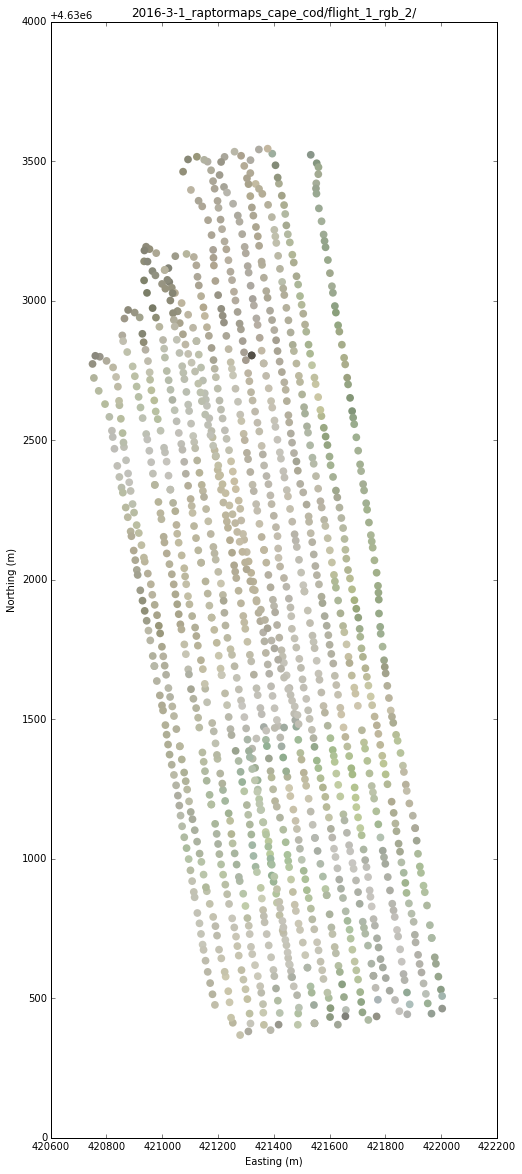

In [27]:
# plot UTM x,y with average image color

ss = np.ones_like(x[1,:])*20.
fig,ax = plt.subplots(figsize=(8,20))
for i in range(len(x[0,:])):
    ax.scatter(x[8,i],x[9,i],s=60,c=rgb[:,i],edgecolors='none')
    
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title(imdir)
#plt.xlim(4206000,422200)
#plt.ylim(4630000,4634000)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.savefig(tdir+imdir+'track.png')